In [1]:
import torch, transformers, datasets, evaluate, sklearn, matplotlib
print("cuda:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)


C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda: True
torch: 2.3.1+cu121
transformers: 4.44.2
datasets: 2.19.0
evaluate: 0.4.1


###加载 IMDb

In [2]:
import os, random, numpy as np, torch
from datasets import load_dataset
from collections import Counter

# 关掉 tokenizer 的并行提示
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 1) 加载 IMDb
imdb = load_dataset("imdb")
print(imdb)

# 2) 看一眼样本
print("\nSample text:", imdb["train"][0]["text"][:200].replace("\n"," ") + " ...")
print("Sample label:", imdb["train"][0]["label"], "(0=neg, 1=pos)")

# 3) 类别分布
cnt_train = Counter(imdb["train"]["label"])
cnt_test = Counter(imdb["test"]["label"])
print("\nTrain label counts:", cnt_train)
print("Test  label counts:", cnt_test)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Sample text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev ...
Sample label: 0 (0=neg, 1=pos)

Train label counts: Counter({0: 12500, 1: 12500})
Test  label counts: Counter({0: 12500, 1: 12500})


###数据集划分

In [3]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import DatasetDict

# 1) 选择检查点与分词器
ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)

# 2) 建一个验证集，从训练集里按 9:1 切出来
imdb_split = imdb["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
imdb_proc = DatasetDict({
    "train": imdb_split["train"],
    "val": imdb_split["test"],
    "test": imdb["test"]
})

# 3) 分词函数
def tok_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,           # 先不静态 padding，后面用动态 padding
        max_length=256
    )

# 4) 批量映射，去掉原文本，只保留 label
imdb_tok = imdb_proc.map(tok_fn, batched=True, remove_columns=["text"])

# 5) 设置成 PyTorch 格式
imdb_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 6) 动态 padding 的 collator
collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

# 7) 快速检查一个 batch 的形状
from torch.utils.data import DataLoader
tmp_loader = DataLoader(imdb_tok["train"], batch_size=8, shuffle=True, collate_fn=collator)
batch = next(iter(tmp_loader))
{k: v.shape for k, v in batch.items()}


C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 25000/25000 [00:18<00:00, 1320.99 examples/s]


{'input_ids': torch.Size([8, 256]),
 'attention_mask': torch.Size([8, 256]),
 'labels': torch.Size([8])}

In [4]:
import os, random, numpy as np, torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# 0) 如果你已经有 imdb, imdb_tok, collator，就跳过准备；没有就自动准备
try:
    imdb_tok, collator
except NameError:
    imdb = load_dataset("imdb")
    ckpt = "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    imdb_split = imdb["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
    imdb_proc = DatasetDict({
        "train": imdb_split["train"],
        "val": imdb_split["test"],
        "test": imdb["test"]
    })
    def tok_fn(batch):
        return tokenizer(batch["text"], truncation=True, padding=False, max_length=256)
    imdb_tok = imdb_proc.map(tok_fn, batched=True, remove_columns=["text"])
    imdb_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)
else:
    # 如果在上一个单元你已经定义过 tokenizer，就复用；否则再加载一次
    try:
        tokenizer
    except NameError:
        tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)

# 1) 加载模型（IMDb 二分类，num_labels=2）
id2label = {0: "neg", 1: "pos"}
label2id = {"neg": 0, "pos": 1}
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# 2) 指标函数：precision / recall / f1 / accuracy（按正类 pos=1 计算二分类）
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}

# 3) 训练参数
args = TrainingArguments(
    output_dir="./out_imdb_roberta",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    bf16=torch.cuda.is_available(),  # 有新显卡就用 bf16
    report_to="none"
)

# 4) Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=imdb_tok["train"],
    eval_dataset=imdb_tok["val"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

# 5) 训练
trainer.train()

# 6) 在验证集与测试集评估
print("\n[VAL]")
val_metrics = trainer.evaluate(eval_dataset=imdb_tok["val"])
print(val_metrics)

print("\n[TEST]")
test_metrics = trainer.evaluate(eval_dataset=imdb_tok["test"])
print(test_metrics)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Li1000\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this a

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.266200,0.268644,0.950596,0.892800,0.920792,0.923200
2,0.185700,0.251350,0.942742,0.935200,0.938956,0.939200



[VAL]


{'eval_loss': 0.25134992599487305, 'eval_precision': 0.942741935483871, 'eval_recall': 0.9352, 'eval_f1': 0.9389558232931727, 'eval_accuracy': 0.9392, 'eval_runtime': 14.6673, 'eval_samples_per_second': 170.447, 'eval_steps_per_second': 5.386, 'epoch': 2.0}

[TEST]
{'eval_loss': 0.25308701395988464, 'eval_precision': 0.9340562953512479, 'eval_recall': 0.93712, 'eval_f1': 0.9355856395511362, 'eval_accuracy': 0.93548, 'eval_runtime': 160.4317, 'eval_samples_per_second': 155.83, 'eval_steps_per_second': 4.874, 'epoch': 2.0}


TN=11673, FP=827, FN=785, TP=11715
{'precision': 0.9340615531813108, 'recall': 0.9372, 'f1': 0.9356281447168756, 'accuracy': 0.93552}


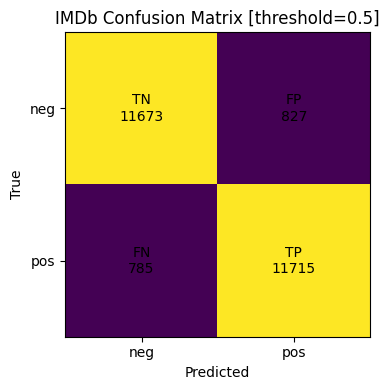

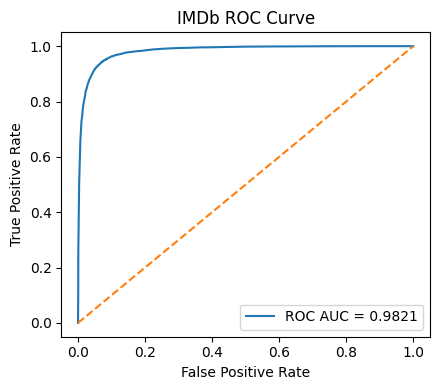

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score

# 1) 拿测试集预测与概率
pred = trainer.predict(imdb_tok["test"])
logits = pred.predictions
y_true = pred.label_ids

# 二分类正类概率，labels 为 [neg, pos]，取第 1 列
probs_pos = torch.softmax(torch.from_numpy(logits), dim=1)[:, 1].numpy()

# 2) 用 0.5 阈值得到离散预测
y_pred = (probs_pos >= 0.5).astype(int)

# 3) 计算混淆矩阵与指标
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=1, zero_division=0
)
acc = accuracy_score(y_true, y_pred)

print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print({"precision": precision, "recall": recall, "f1": f1, "accuracy": acc})

# 4) 绘制混淆矩阵，标注 TP FP TN FN
fig1 = plt.figure(figsize=(4.5, 4))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("IMDb Confusion Matrix [threshold=0.5]")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["neg", "pos"]); ax.set_yticklabels(["neg", "pos"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")

# 在格子里写数值与标签
labels_text = np.array([["TN", "FP"], ["FN", "TP"]])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{labels_text[i, j]}\n{cm[i, j]}", ha="center", va="center")

plt.tight_layout()
plt.show()

# 5) 绘制 ROC 曲线与 AUC
fpr, tpr, _ = roc_curve(y_true, probs_pos, pos_label=1)
roc_auc = auc(fpr, tpr)

fig2 = plt.figure(figsize=(4.5, 4))
ax2 = plt.gca()
ax2.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
ax2.plot([0, 1], [0, 1], linestyle="--")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("IMDb ROC Curve")
ax2.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
SST-2 加载

In [6]:
import os, random, numpy as np, torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)

# 1) 加载 GLUE 的 SST-2
# 原始划分包含 train/validation/test，其中 test 没有标签
sst2_raw = load_dataset("glue", "sst2")
print(sst2_raw)

# 2) 我们从 train 中切出 10% 当作校验集，保留官方 validation 作为最终报告的“测试”集
# 这样既有早停/挑最佳模型的 val，又有独立评估集
split = sst2_raw["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
sst2_proc = DatasetDict({
    "train": split["train"],
    "val": split["test"],
    "test": sst2_raw["validation"]  # 官方 validation 当作我们的测试集
})

# 3) roberta-base 分词
ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)

def tok_fn(batch):
    # 原字段名是 'sentence' 和 'label'
    return tokenizer(batch["sentence"], truncation=True, padding=False, max_length=256)

sst2_tok = sst2_proc.map(tok_fn, batched=True, remove_columns=["sentence"])

# 4) 设为 torch 张量
sst2_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 5) 动态 padding collator
sst2_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

# 6) 快速查看一个样本的形状（避免 DataLoader 触发 numpy 的老坑）
sample = sst2_tok["train"][0]
{k: (v.shape if hasattr(v, "shape") else type(v)) for k, v in sample.items()}


Generating test split: 100%|██████████| 1821/1821 [00:00<00:00, 455880.84 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 872/872 [00:00<00:00, 10565.61 examples/s]


{'label': torch.Size([]),
 'input_ids': torch.Size([7]),
 'attention_mask': torch.Size([7])}

In [7]:
import os, random, numpy as np, torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

set_seed(42)

# 0) 如果你已经有 sst2_tok, sst2_collator, tokenizer，就复用；否则自动准备
try:
    sst2_tok, sst2_collator, tokenizer
except NameError:
    # 加载 GLUE 的 SST-2
    sst2_raw = load_dataset("glue", "sst2")
    # 从 train 切 10% 当验证集，官方 validation 作为最终测试集
    split = sst2_raw["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
    sst2_proc = DatasetDict({
        "train": split["train"],
        "val": split["test"],
        "test": sst2_raw["validation"]
    })
    # 分词
    tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
    def tok_fn(batch):
        return tokenizer(batch["sentence"], truncation=True, padding=False, max_length=256)
    sst2_tok = sst2_proc.map(tok_fn, batched=True, remove_columns=["sentence"])
    sst2_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    sst2_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

# 1) 模型，SST-2 二分类，0=neg，1=pos
id2label = {0: "neg", 1: "pos"}
label2id = {"neg": 0, "pos": 1}
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# 2) 指标函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": acc}

# 3) 训练参数
args = TrainingArguments(
    output_dir="./out_sst2_roberta",
    num_train_epochs=2,                      # 先跑 2 个 epoch 验证流程
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    bf16=torch.cuda.is_available(),
    report_to="none"
)

# 4) Trainer
trainer_sst2 = Trainer(
    model=model,
    args=args,
    train_dataset=sst2_tok["train"],
    eval_dataset=sst2_tok["val"],
    tokenizer=tokenizer,
    data_collator=sst2_collator,
    compute_metrics=compute_metrics
)

# 5) 训练
trainer_sst2.train()

# 6) 评估
print("\n[VAL]")
val_metrics = trainer_sst2.evaluate(eval_dataset=sst2_tok["val"])
print(val_metrics)

print("\n[TEST]")
test_metrics = trainer_sst2.evaluate(eval_dataset=sst2_tok["test"])
print(test_metrics)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.275000,0.227868,0.939736,0.929731,0.934707,0.927543
2,0.191600,0.202782,0.945133,0.953686,0.949391,0.943281



[VAL]


{'eval_loss': 0.20278218388557434, 'eval_precision': 0.9451332102347666, 'eval_recall': 0.9536864519563482, 'eval_f1': 0.9493905670376258, 'eval_accuracy': 0.9432813659985152, 'eval_runtime': 10.4745, 'eval_samples_per_second': 642.989, 'eval_steps_per_second': 20.144, 'epoch': 2.0}

[TEST]
{'eval_loss': 0.2849898040294647, 'eval_precision': 0.9021739130434783, 'eval_recall': 0.9346846846846847, 'eval_f1': 0.918141592920354, 'eval_accuracy': 0.9151376146788991, 'eval_runtime': 3.0054, 'eval_samples_per_second': 290.143, 'eval_steps_per_second': 9.317, 'epoch': 2.0}


TN=383, FP=45, FN=29, TP=415
{'precision': 0.9021739130434783, 'recall': 0.9346846846846847, 'f1': 0.918141592920354, 'accuracy': 0.9151376146788991}


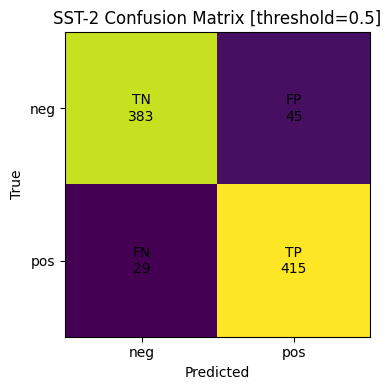

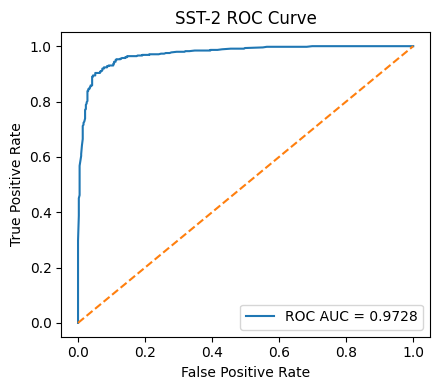

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score

# 1) 拿测试集预测与概率
pred_sst2 = trainer_sst2.predict(sst2_tok["test"])
logits = pred_sst2.predictions
y_true = pred_sst2.label_ids

# roberta 二分类 [neg, pos]，取正类概率
probs_pos = torch.softmax(torch.from_numpy(logits), dim=1)[:, 1].numpy()

# 2) 用 0.5 阈值得到离散预测
th = 0.5
y_pred = (probs_pos >= th).astype(int)

# 3) 混淆矩阵与指标
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=1, zero_division=0
)
acc = accuracy_score(y_true, y_pred)

print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print({"precision": precision, "recall": recall, "f1": f1, "accuracy": acc})

# 4) 画混淆矩阵，标注 TP FP TN FN
fig1 = plt.figure(figsize=(4.5, 4))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title(f"SST-2 Confusion Matrix [threshold={th}]")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["neg", "pos"]); ax.set_yticklabels(["neg", "pos"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")

labels_text = np.array([["TN", "FP"], ["FN", "TP"]])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{labels_text[i, j]}\n{cm[i, j]}", ha="center", va="center")

plt.tight_layout()
plt.show()

# 5) 画 ROC 曲线与 AUC
fpr, tpr, _ = roc_curve(y_true, probs_pos, pos_label=1)
roc_auc = auc(fpr, tpr)

fig2 = plt.figure(figsize=(4.5, 4))
ax2 = plt.gca()
ax2.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
ax2.plot([0, 1], [0, 1], linestyle="--")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("SST-2 ROC Curve")
ax2.legend(loc="lower right")
plt.tight_layout()
plt.show()


AG news

In [1]:
import os, random, numpy as np, torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cuda.matmul.allow_tf32 = True  # Ampere 及以上有用
torch.backends.cudnn.allow_tf32 = True

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# =============== 可调的提速开关 ===============
CKPT = "distilroberta-base"   # 更轻的模型
MAX_LEN = 128                  # 降低序列长度
USE_SUBSET = True              # 是否只用部分训练样本
TRAIN_SIZE = 60000             # 子集大小，四类均衡抽样
EPOCHS = 2                     # 先跑 2 个 epoch
TRAIN_BS = 32                  # 视显存可调 16/32
EVAL_BS = 64
EVAL_STEPS = 2000              # 每隔多少步评估一次
LOG_STEPS = 100
# ============================================

# 1) 加载并划分
ag_raw = load_dataset("ag_news")
split = ag_raw["train"].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
train_full = split["train"]
val_ds = split["test"]
test_ds = ag_raw["test"]

# 可选, 从 108k 的 train 中抽取 60k，保持标签分布
if USE_SUBSET:
    # 按标签分层抽样
    n_per_class = TRAIN_SIZE // 4
    keep_idx = []
    labels = train_full["label"]
    by_class = {c: [] for c in range(4)}
    for i, y in enumerate(labels): by_class[y].append(i)
    rng = np.random.default_rng(42)
    for c in range(4):
        sel = rng.choice(by_class[c], size=n_per_class, replace=False)
        keep_idx.extend(sel.tolist())
    keep_idx = sorted(keep_idx)
    train_ds = train_full.select(keep_idx)
else:
    train_ds = train_full

ag_proc = DatasetDict({"train": train_ds, "val": val_ds, "test": test_ds})

# 2) 分词
tokenizer = AutoTokenizer.from_pretrained(CKPT, use_fast=True)
def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=MAX_LEN)

ag_tok = ag_proc.map(tok_fn, batched=True, remove_columns=["text"])
ag_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
collator_ag = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

# 3) 模型（4 类）
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}
model_ag = AutoModelForSequenceClassification.from_pretrained(
    CKPT, num_labels=4, id2label=id2label, label2id=label2id
)

# 4) 指标
def compute_metrics_ag(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"precision_macro": p, "recall_macro": r, "f1_macro": f1, "accuracy": acc}

# 5) 训练参数，减少评估与保存开销
use_bf16 = torch.cuda.is_available()
args_ag = TrainingArguments(
    output_dir="./out_agnews_distilroberta_fast",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="no",                 # 不保存 checkpoint，最省时间与磁盘
    logging_steps=LOG_STEPS,
    bf16=use_bf16,                      # 如果你的卡支持 bf16，会用上
    fp16=not use_bf16,                  # 否则走 fp16
    optim="adamw_torch_fused",          # CUDA 上更快
    report_to="none",
    dataloader_num_workers=4,           # 视机器可调到 8
)

# 6) Trainer
trainer_ag_fast = Trainer(
    model=model_ag,
    args=args_ag,
    train_dataset=ag_tok["train"],
    eval_dataset=ag_tok["val"],
    tokenizer=tokenizer,
    data_collator=collator_ag,
    compute_metrics=compute_metrics_ag
)

# 7) 训练与评估
trainer_ag_fast.train()

print("\n[VAL]")
val_metrics_ag = trainer_ag_fast.evaluate(eval_dataset=ag_tok["val"])
print(val_metrics_ag)

print("\n[TEST]")
test_metrics_ag = trainer_ag_fast.evaluate(eval_dataset=ag_tok["test"])
print(test_metrics_ag)


C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Li1000\Desktop\Dissertation\EE6405\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Li1000\.cache\huggingface\hub\models--distilroberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. 

Step,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
2000,0.161200,0.215487,0.932384,0.931750,0.931997,0.931750



[VAL]


{'eval_loss': 0.18310058116912842, 'eval_precision_macro': 0.942827232195182, 'eval_recall_macro': 0.9425, 'eval_f1_macro': 0.9424446248583057, 'eval_accuracy': 0.9425, 'eval_runtime': 29.8828, 'eval_samples_per_second': 401.569, 'eval_steps_per_second': 6.291, 'epoch': 2.0}

[TEST]
{'eval_loss': 0.1805841326713562, 'eval_precision_macro': 0.9430669821264059, 'eval_recall_macro': 0.9428947368421052, 'eval_f1_macro': 0.9428141758816166, 'eval_accuracy': 0.9428947368421052, 'eval_runtime': 25.8961, 'eval_samples_per_second': 293.481, 'eval_steps_per_second': 4.595, 'epoch': 2.0}


{'accuracy': 0.9428947368421052, 'precision_macro': 0.9430669821264059, 'recall_macro': 0.9428947368421052, 'f1_macro': 0.9428141758816166}


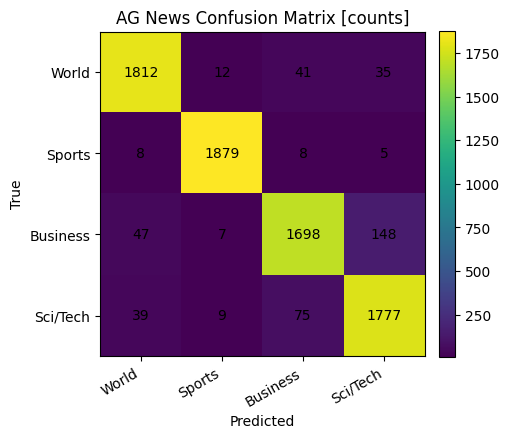

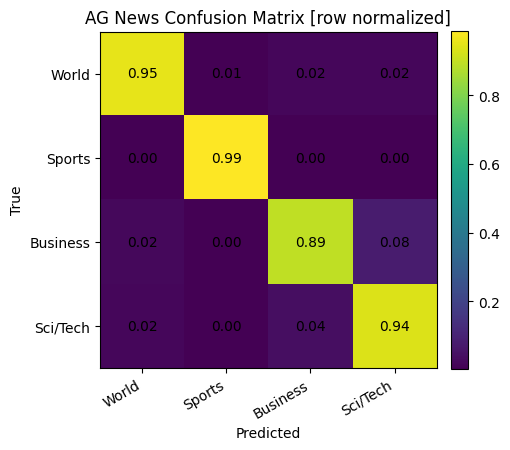


Per class report:
              precision    recall  f1-score   support

       World     0.9507    0.9537    0.9522      1900
      Sports     0.9853    0.9889    0.9871      1900
    Business     0.9319    0.8937    0.9124      1900
    Sci/Tech     0.9043    0.9353    0.9195      1900

    accuracy                         0.9429      7600
   macro avg     0.9431    0.9429    0.9428      7600
weighted avg     0.9431    0.9429    0.9428      7600



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# 1) 预测
pred_test = trainer_ag_fast.predict(ag_tok["test"])
y_true = pred_test.label_ids
y_pred = pred_test.predictions.argmax(axis=-1)

# 2) 指标摘要
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
acc = accuracy_score(y_true, y_pred)
print({"accuracy": acc, "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro})

# 3) 混淆矩阵, 计数与归一化
labels_order = [0, 1, 2, 3]
tick_names = [id2label[i] for i in labels_order]

cm = confusion_matrix(y_true, y_pred, labels=labels_order)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

def plot_cm(mat, title, tick_names, fmt=".2f", is_int=False):
    fig = plt.figure(figsize=(5.2, 4.8))
    ax = plt.gca()
    im = ax.imshow(mat, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(tick_names)))
    ax.set_yticks(np.arange(len(tick_names)))
    ax.set_xticklabels(tick_names, rotation=30, ha="right")
    ax.set_yticklabels(tick_names)

    # 标注数字
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            text = f"{int(mat[i, j])}" if is_int else f"{mat[i, j]:{fmt}}"
            ax.text(j, i, text, ha="center", va="center")

    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# 计数矩阵
plot_cm(cm, "AG News Confusion Matrix [counts]", tick_names, is_int=True)
# 按行归一化矩阵
plot_cm(cm_norm, "AG News Confusion Matrix [row normalized]", tick_names, fmt=".2f")

# 4) 如需每类详细报告
print("\nPer class report:")
print(classification_report(y_true, y_pred, target_names=tick_names, digits=4))
